Todo (2023.01.22):
1. Compare multi phi theta's with single phi thetas
2. compare multi phi theta's with Ben Lehner's reported thetas
3. Compare shapes of multi phi model with single phi models
4. Implement multi-phi-GE regression (i.e. multi-GE measurement process will be needed) and compare performances
5. Plot phi_1 and phi_2 vs. measured binding values
6. Write this all up in report/packet and include single theta model results and brief summary of assays.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

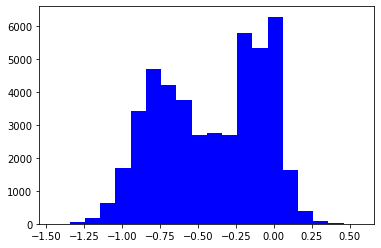

In [8]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [9]:
#gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

gpmapGE = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)

#gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsistasisMP(K=50,
                                                           monotonic=True,
                                                           number_latent_nodes=2,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [10]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [11]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

2023-01-26 07:54:10.232121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Exception encountered when calling layer "multi_latent_global_epistasis_layer" (type MultiLatentGlobalEpistasisLayer).

in user code:

    File "/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/src/layers/measurement_process_layers.py", line 1763, in call  *
        return self.phi_to_yhat(phi)
    File "/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/src/layers/measurement_process_layers.py", line 1804, in wrapped_func  *
        result = func(*args, **kwargs)
    File "/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/src/layers/measurement_process_layers.py", line 1775, in phi_to_yhat  *
        yhat = self.a_0 + tf.reshape(

    ValueError: Dimensions must be equal, but are 50 and 2 for '{{node multi_latent_global_epistasis_layer/mul}} = Mul[T=DT_FLOAT](multi_latent_global_epistasis_layer/Reshape_1, multi_latent_global_epistasis_layer/Reshape_3)' with input shapes: [1,2,50], [?,2].


Call arguments received:
  • phi=tf.Tensor(shape=(None, 2), dtype=float32)

In [ ]:
model_GE.model.summary()

In [12]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

NameError: name 'model_GE' is not defined

On test data:


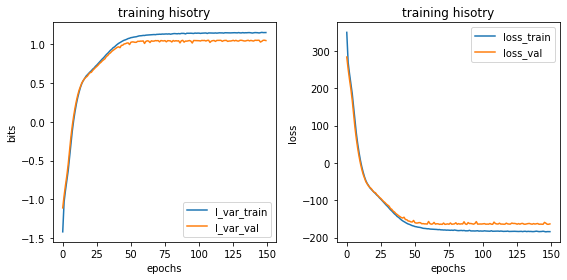

In [27]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [28]:
phi = gpmapGE.x_to_phi(x_test_GE)
phi_train = gpmapGE.x_to_phi(x_train_GE)

In [29]:
np.corrcoef(phi_train,y_train_GE)[0,1]**2

0.7864615565098959

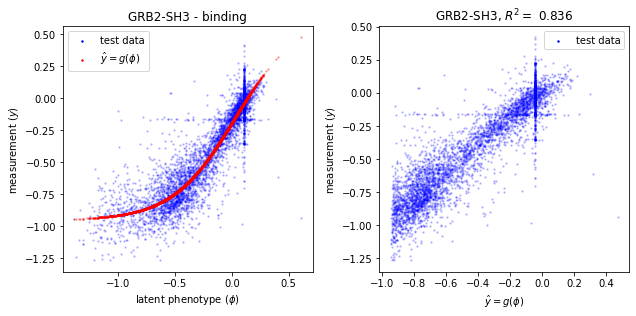

In [30]:
fig, axs = plt.subplots(1,2, figsize=(9,4.5))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(phi,yhat,s=2,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GRB2-SH3 - binding')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
#fig.savefig('plots/GRB2_SH3/global_epistasis_binding_binding.png',dpi=300,bbox_inches='tight')    


In [31]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

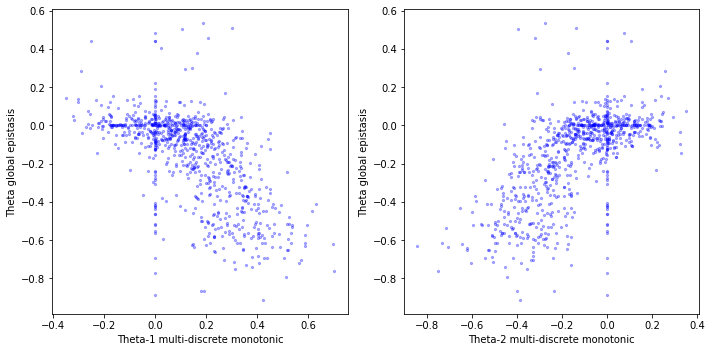

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(theta_2_lc[0].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[0].set_xlabel('Theta-1 multi-discrete monotonic')
ax[0].set_ylabel('Theta global epistasis')

ax[1].scatter(theta_2_lc[1].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[1].set_xlabel('Theta-2 multi-discrete monotonic')
ax[1].set_ylabel('Theta global epistasis')

fig.tight_layout()

In [33]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv',index_col=[0])
lehner_binding_singles_df

,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
1,1,T,K,NaN,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,2181.666667,0.010464,0.005995
2,1,T,N,NaN,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,16.000000,0.028944,0.087284
3,2,Y,K,NaN,TKVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,23.000000,-0.093964,0.092442
4,2,Y,N,NaN,TNVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,8892.666667,-0.035080,0.004516
5,2,Y,S,NaN,TSVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,54.666667,0.044625,0.027825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,1,T,A,NaN,AYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,11058.666667,-0.013506,0.004341
708,1,T,G,NaN,GYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,14.000000,-0.012349,0.071471
709,1,T,V,NaN,VYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,57.000000,-0.002641,0.028864
710,1,T,*,NaN,*YVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,True,False,15.000000,-0.219692,0.074135


In [34]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

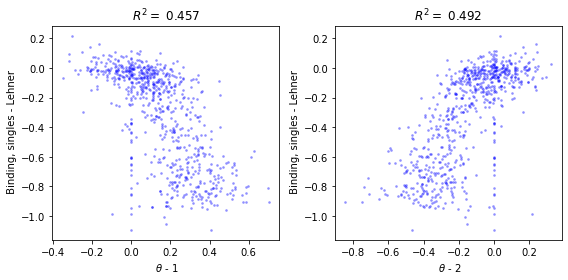

In [36]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_2_lc[0].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[0].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 1')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_2_lc[1].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[1].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 2')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

#fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


Text(0.5, 1.0, 'Lehner - binding')

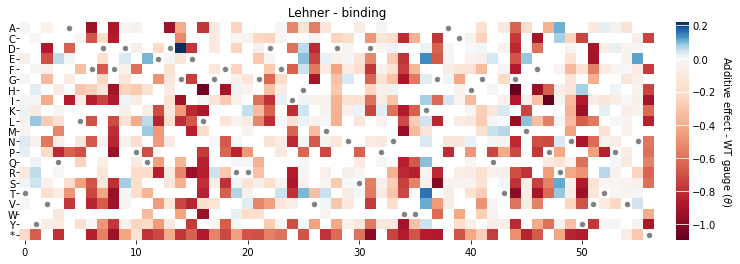

In [37]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

#fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')